# COGS 118A - Final Project

# Project Title: Fraudulent Transactions Detection
## Group members

- Xiaotong Zeng
- Yandong Xiang
- Xiang Li
- Jiaxin Ye

# Abstract 

The goal of this project is to predict whether a transaction is fraudulent given identity and transaction information. The dataset that we are using contains two files: identity and transaction, which are joined by the “TransactionID” variable. The identity dataset contains network connection information and digital signature associated with transactions, and the transaction dataset contains transaction amounts, card information, product of each transaction, and other related information. We will first perform data cleaning, data engineering, and PCA on the datasets. Then, we will use Naive Bayes as our baseline model, and we will compare it with the performances of RandomForest, LightGBM, and XGBoost to determine which model we will eventually use for this prediction task. In terms of evaluating the performance of our model, we will be using recall scores primarily since false negatives are more costly in fraud detection, so we do not want to predict a transaction as normal when it is actually fraudulent. But we will also take precision, accuracy, and F1 score into consideration for the balance of our model predictions.

# Background

Nowadays, electronic payments have become an indispensable part of people’s everyday lives. It is an ongoing trend that digital wallets have replaced physical wallets. But as this trend evolves, many unscrupulous people see the opportunity of making illegal profits out of it, i.e. through transaction fraud. Online transaction fraud occurs when a fraudster attempts to conduct a transaction using another person’s identity and payment information<a name="Sasso"></a>[<sup>[1]</sup>](#Sasso). According to the Federal Trade Commission (FTC), there was a total of 5.8 billion dollars of loss through fraud in 2021 for a 70 percent year-over-year increase<a name="Skiba"></a>[<sup>[2]</sup>](#Skiba). In addition to ostensible monetary losses on the consumers’ sides, the fraud also induces negative impacts on customer/reputational, operational and topline revenue implications on the merchants’ sides<a name="McKee"></a>[<sup>[3]</sup>](#McKee). If the merchants impose a restrictive fraud control policy, this can diminish the consumer experience. It is also time-consuming and labor-intensive for merchants to maintain anti-fraud technology. In terms of topline revenue, merchants may tend to avoid new revenue opportunities, such as entering a foreign market, due to concerns over fraud. Thus, it is of great importance to develop fraud detection algorithms to protect both consumers and merchants, and to provide a safe e-payment environment in general. In particular, machine learning techniques are widely used in fraud detection nowadays, and it is far more accurate than the traditional manual process. In the late 20th century, the companies spotted frauds through simple rules. For example, if a transaction exceeds 10,000 dollars, then there was a high risk of fraud. However, this was a static method since it could not keep up with the changing customer behavior promptly. That is, it was not effective in terms of adjusting to new fraud patterns. So, machine learning models are a better choice since it allows automation and self-adaptiveness. They learn which transactions are normal and which are anomalous<a name="Oakley"></a>[<sup>[4]</sup>](#Oakley). However, a problem that we would encounter is the issue of imbalanced data. In the real world, most transactions are valid and only a small portion are fraud transactions<a name="Pykes"></a>[<sup>[5]</sup>](#Pykes). Thus, we need to take this into account when we deal with our dataset.

# Problem Statement

The problem is to predict whether a transaction is fraudulent using features such as card, address, email, device information, etc. Fraudulence is a big issue since it harms both customers and merchants, and the society in general. Historical methods of detecting fraud transactions were based on simple rules that may not be able to catch the complicated patterns in the data. The objective of this project is to predict if a transaction is fraudulent (label 1 means fraudulent, and label 0 means normal) through experimenting with different machine learning models and selecting the one with the highest recall score.

# Data

### Meta Data

identity.csv
- https://www.kaggle.com/competitions/ieee-fraud-detection/data?select=train_identity.csv
- (41 variables, 144233 observations)
- Consists of: DeviceType, DeviceInfo, id_01 - id_38, TransactionID
    - DeviceType: type of device used, such as mobile and desktop, etc
    - DeviceInfo: The system used by the device
    - Transaction ID: id for the transaction made
    - id_01 - id_38: network connection and digital signature information
- Critical variables: id_12 - id_38(float), Device type(‘string’),  Device Info(‘string’)
- Convert device type to is mobile: if is mobile, True, else False
- Onehot encode Device Info, Their are 1786 unique device software. Keep the software in the top 20 ocurrances of the dataset and set rest of them as “Others” [to 21 columns].


transaction.csv
- https://www.kaggle.com/competitions/ieee-fraud-detection/data?select=train_transaction.csv
- (394 variables, 590540 observations)
- Consists of: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1-M9, C1-C14, D1-D15, V1 - V339, TransactionDT, TransactionAmt, dist1 - dist2
    - isFraud: the label of dataset
    - ProductCD: The code of the Product 
    - TransactionAmt: Transaction amount
    - TransactionDT: Transaction datetime
    - P_emaildomain: purchaser email domain
    - R_emaildomain: recipient email domain
    - card1 - card6: payment card information
    - addr1: billing region
    - addr2: billing country
    - dist1 - dist2: distance between different address
    - M1-M9: matches between info provided
    - C1-C14: count of address associated with the card
    - D1-D15: days between previous transactions
    - V1 - V339: Vesta engineered rich features
- Critical variables: card1 - card6(Int), addr1(float), addr2(float), M1-M9(boolean), C1-C14(float), D1-D15(float), V1 - V339(float), TransactionDT, TransactionAmt, dist1 - dist2, ProductCD(string), P_emaildomain(string), R_emaildomain(string), TransactionAmt(float)
- Convert ProductCD to is W: if is W, True, else False.
- Onehot encode P_emaildomain[to 59 columns] and R_emaildomain[to 60 columns].

### Data Preprocessing
Due to the abundance of transaction data as compared to identity data, we have chosen to utilize transaction data as the primary predictors in our analysis. To achieve this, we have performed a left join on the "TransactionID" column, merging the two dataframes. This merge retains all the records from the transaction dataframe and adds matched records from the identity dataframe. Consequently, our final dataset is a merged dataset containing 590540 rows and 434 columns. Because we have a total of 434 columns, it is difficult to check correlation between each column and the predicted label. Therefore, we used our intuition and domain knowledge to select a subset of features that we thought could be effective in predicting whether or not the transaction is fraudulent.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.model_selection import KFold
import warnings 
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

C:\Users\tony_\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\tony_\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\tony_\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
print(train_df.shape)

(590540, 434)


### Fixing the issue of unbalanced labels

We observed significantly less fraud data in our dataset. In order to create a model that predicts both class accurately, we decide to balance the labels by downsampling, as oversampling would lead to overfitting.

In [3]:
train_is_fraud = train_df[train_df['isFraud']==1].sample(replace=False, n=len(train_df[train_df['isFraud']==1]))
train_is_not_fraud = train_df[train_df['isFraud']==0].sample(replace=False, n=len(train_is_fraud))
train_df = pd.concat([train_is_fraud, train_is_not_fraud])
print(train_df.shape)
train_df['isFraud'].value_counts()

(41326, 434)


1    20663
0    20663
Name: isFraud, dtype: int64

### Data Cleaning
1. **Convert TransactionDT into Transaction Day and Transaction Hour**
    - Justification: TransactionDT measures the time from a given reference datetime (not an actual timestamp), therefore, in order to better utilize the cycling attribute of time. We decide to convert TransactionDT to specific day and hours. In our EDAs, we also tried to convert TransactionDT into week and month. However, we did not have any particular patterns that differentiates the weeks or months. Therefore, we will only keep day and hour in our final table.

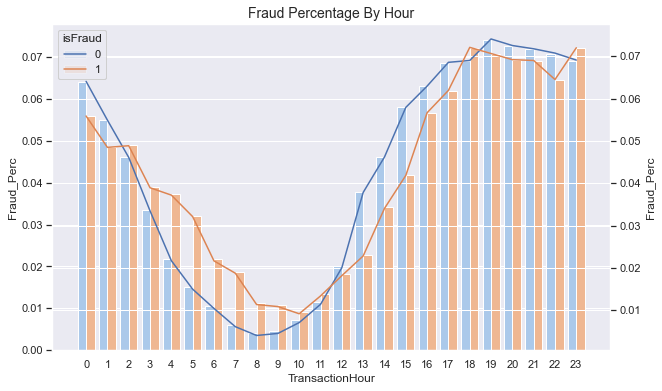

In [4]:
#Transform TransactionDT into Hour, Day of Week
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)

fraud_hour_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionHour'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_hour_perc_df = fraud_hour_perc / fraud_hour_perc.groupby(level=0).sum()
fraud_hour_perc_df = fraud_hour_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Hour', fontsize=14)
ax1 = sns.barplot(x="TransactionHour", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_hour_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionHour', y='Fraud_Perc', data = fraud_hour_perc_df, sort=False, hue="isFraud")
plt.show()

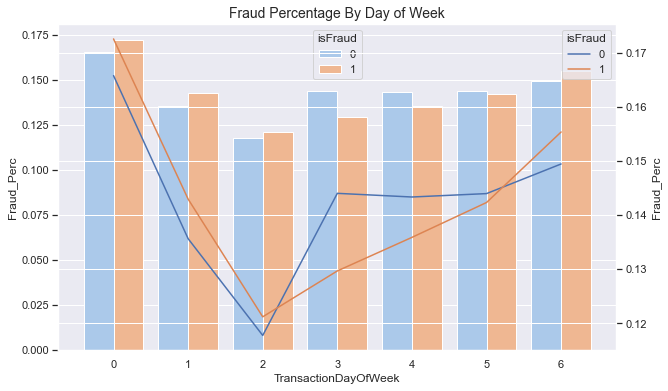

In [5]:
fraud_dow_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionDayOfWeek'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_dow_perc_df = fraud_dow_perc / fraud_dow_perc.groupby(level=0).sum()
fraud_dow_perc_df = fraud_dow_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Day of Week', fontsize=14)
ax1 = sns.barplot(x="TransactionDayOfWeek", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_dow_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionDayOfWeek', y='Fraud_Perc', data = fraud_dow_perc_df, sort=False, hue="isFraud")
plt.show()

2. **Apply Log Transformation to Transaction Amount**
    - In our EDA, we used a boxplot to plot the distribution of the transaction amount and found that the transaction amount is significantly skewed to the right which means that most of our transactions are below $200. In order to reduce the skewness of the data, we decide to apply a log transformation to the Transaction Amount to make the variable seem more normally distributed.

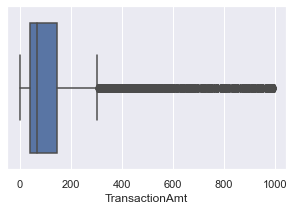

In [6]:
#Remove outliers
fig, ax = plt.subplots(figsize=(5,3))
transaction_amount = train_df[train_df['TransactionAmt'] < 1000]['TransactionAmt']
ax = sns.boxplot(transaction_amount)

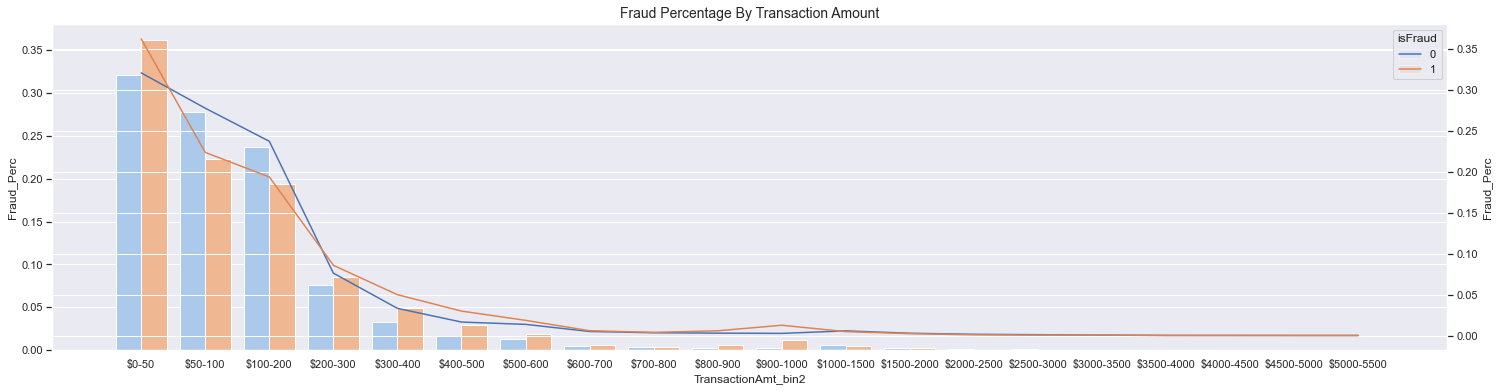

In [7]:
def convert_to_bin_amt(x):
    if x < 50:
        return '$0-50'
    elif x < 100:
        return '$50-100'
    elif x < 200:
        return '$100-200'
    elif x < 300:
        return '$200-300'
    elif x < 400:
        return '$300-400'
    elif x < 500:
        return '$400-500'
    elif x < 600:
        return '$500-600'
    elif x < 700:
        return '$600-700'
    elif x < 800:
        return '$700-800'
    elif x < 900:
        return '$800-900'
    elif x < 1000:
        return '$900-1000'
    elif x < 1500:
        return '$1000-1500'
    elif x < 2000:
        return '$1500-2000'
    elif x < 2500:
        return '$2000-2500'
    elif x < 3000:
        return '$2500-3000'
    elif x < 3500:
        return '$3000-3500'
    elif x < 4000:
        return '$3500-4000'
    elif x < 4500:
        return '$4000-4500'
    elif x < 5000:
        return '$4500-5000'
    elif x < 5500:
        return '$5000-5500'
    elif x < 6000:
        return '$5500-6000'
    elif x < 6500:
        return '$6000-6500'
    elif x < 7000:
        return '$6500-7000'
    elif x < 7500:
        return '$7000-7500'
    elif x < 8000:
        return '$7500-8000'
    elif x < 8500:
        return '$8000-8500'
    elif x < 9000:
        return '$8500-9000'
    elif x < 9500:
        return '$9000-9500'
    elif x < 10000:
        return '$9500-10000'
    else:
        return '$10000-+'
    
train_df['TransactionAmt_bin2'] = train_df['TransactionAmt'].apply(convert_to_bin_amt)
fraud_amount = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionAmt_bin2'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_amount_df = fraud_amount / fraud_amount.groupby(level=0).sum()
fraud_amount_df = fraud_amount_df.reset_index()
fraud_amount_df['index_2'] = fraud_amount_df['TransactionAmt_bin2'].apply(lambda x: float(x.split('-')[0][1:]))
fraud_amount_df = fraud_amount_df.sort_values(by=['index_2'], ascending=True)
fig, ax1 = plt.subplots(figsize=(25,6))
ax1.set_title('Fraud Percentage By Transaction Amount', fontsize=14)
ax1 = sns.barplot(x="TransactionAmt_bin2", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_amount_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionAmt_bin2', y='Fraud_Perc', data=fraud_amount_df, sort=True, hue="isFraud")
plt.show()

3. **One-hot encode the Addresses, Email Domains, and Device Infos, IDs Infos into popular values and others**
    - During our exploratory analysis, we realized that certain addresses, email domains, and device infos are more likely to be associated with fraudulent transactions. Originally, we plan to one hot encode all the values in these columns. However, there are too many unique values in these columns and some of them do not have an siginificant influence on predicting whether or not the transaction is fraudulent. Therefore, in order to simplify our one-hot features but also capturing all the relevant values, we decide to keep the labels for the most common values (top 100 values) and transform the rest of the less frequent values into another category called "Others". 

In [8]:
def addr1_transform(x):
    if x in top_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def device_info_transform(x):
    if x in top_device_info:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def transform_i(x):
    if x in top_i:
        return str(x)
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
# Convert transactionDT into day of week and hour
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

#addr1, addr2
top_addr1 = list(train_df['addr1'].value_counts().index)[:100] #top ten regions
top_addr2 = list(train_df['addr2'].value_counts().index)[:100] #top ten countries
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)

#Email_Domain
top_email_p = list(train_df['P_emaildomain'].value_counts().index)[:100] 
top_email_r = list(train_df['R_emaildomain'].value_counts().index)[:100] 
train_df['P_emaildomain'].value_counts()
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)

#Device
top_device_info = list(train_df['DeviceInfo'].value_counts().index)[:100] #top device info
train_df['DeviceInfo_new'] = train_df['DeviceInfo'].apply(device_info_transform)

#IDs
id_lst = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 
               'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33']
new_id_lst = [i + '_new' for i in id_lst]
top_i_lst = []
for i in id_lst:
    new_col = i + '_new'
    top_i = list(train_df[i].value_counts().index)[:100]
    top_i_lst.append(top_i)
    train_df[new_col] = train_df[i].apply(transform_i)

4. **Replace numerical missing values with 0 and replace any invalid number with -10 and 10**
    - Since there are many columns with large number of missing data, we decide to replace the missing data for numerical columns with 0 as it will most likely not affect our prediction. Some invalid numbers such as infinity or negative infinity would cause issues in our predictions. Therefore, we decide to replace these invalid number with large numbers such as -10 and 10.

### Cleaned Data Preview

In [9]:
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_10_new,id_11_new,id_13_new,id_14_new,id_17_new,id_19_new,id_20_new,id_30_new,id_31_new,id_33_new
0,3009728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
1,3153664,-5.0,10667.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,...,0.0,96.94000244140624,52.0,-360.0,166.0,322.0,333.0,Windows 7,chrome 63.0,1920x1080
2,3381352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
3,3277854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,3228489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing


# Proposed Solution

To predict whether a transaction is fraudulent or not, we will train and compare several supervised machine learning classifiers using the information about the transactions and the user identities. The first step is to join the transaction table and identity table by transaction id. We will clean up the dataset by removing or imputing the missing or invalid data. Next, we will perform feature engineering by implementing one-hot encoding for the categorical features, standardization for the numerical features, and principal component analysis for all the newly engineered features. Afterwards, we will select the top features and train different classifiers on the feature data. For model selections, we will try Naive Bayes, RandomForest, LightGBM, and XGBoost as they are more suitable for classification tasks and can be trained on large datasets with high-dimensional feature spaces. For performance evaluation, we will split the data into training and testing sets, and use metrics such as accuracy, precision, recall, and F1 score to measure the performance of the classifier on the testing set. We will also use cross-validation to prevent overfitting and use grid search to tune the hyperparameters of the classifier. 
In terms of implementation, we will use scikit-learn, lightGBM, and XGBoost libraries/packages and their functions to preprocess the data and construct the models. For our benchmark model, we plan to use a Naive Bayes classifier and compare it with the performance of the other models (RandomForest, LightGBM, and XGBoost). We will also use grid search to find the optimal hyperparameters for the model.

# Evaluation Metrics

For each observation in the test set, we will predict whether or not the transaction is fraud. To evaluate our model performance, we will be mainly using Confusion Matrix to assess our predictions. In the case of fraud detection, the cost of False Negatives is much higher than the cost of False Positives. To put it into context, we would rather predict transactions that are not fraudulent as fraudulent than predict some transactions that are fraudulent as not fraudulent. **Therefore, we need to focus on getting higher recall.** Meanwhile, we will also control for the balance of our model predictions by looking at accuracy, precision, and F1 score.

- Recall = True Positive / (True Positive + False Negative)
- Precision = True Positive / (True Positive + False Positive)
- F1 = (2 * precision * recall) / (precision + recall)
- Accuracy = (True Positive + True Negative) / (True Positive + False Negative + True Negative + False Positive)



# Results

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.


### 1: Motivation behind Algorithm Selections

Because fraud detection is a binary classification task, we narrowed our selection of algorithms down to Bernoulli Naive Bayes, Random Forest as some basic classifiers. To reach for higher efficiency and accuracy, we also experimented with LightGBM and XGBoost classifiers. 

**Naive Bayes**
- For Naive Bayes, it is a popular probabilistic classifier that works by calculating the probability of a data point belonging to each class based on the input features, and then choosing the class with the highest probability. In fraud detection, Naive Bayes can be used to calculate the probability of a transaction being fraudulent based on input features such as transaction amount, location, and time of day. One of the advantages of Naive Bayes is that it is computationally efficient and can handle a large number of input features. However, it makes the assumption that all input features are independent of each other, which may not always be the case in real-world datasets. 

**Random Forest**
- Random forest is an ensemble method that combines multiple decision trees to improve performance and reduce the chance of overfitting. Random forest can be an effective classifier for fraud detection because it can handle a large number of input features and can identify the most important features for classification.

**LightGBM**
- LightGBM also works well when we have a large dataset with many features. It is a gradient boosting framework that uses decision trees as the base learners and can handle binary classification tasks well. One of the advantages of LightGBM is the speed and scalability. It can train models much faster than other gradient boosting frameworks like XGBoost. Additionally, LightGBM can handle missing data and can automatically handle categorical features.

**XGBoost**
- XGBoost can also be used for fraud detection because it is really effective for handling imbalanced dataset. The nature of fraud detection means that we will have more authentic transactions than fraud transactions. Therefore, handling imbalanced data could be critical in helping us detect the fraud transactions. XGBoost is also a gradient boosting framework that uses decision trees as the base learners and it is really effective in handling missing data and categorical features.





### 2. Feature Engineering - Flame

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data



#### One-Hot Encoding

In [10]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
               'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new',
               'DeviceInfo_new', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'] + new_id_lst
v_col = ['V' + str(i) for i in range(1, 340)]
num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log'] + v_col

to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())

#### PCA

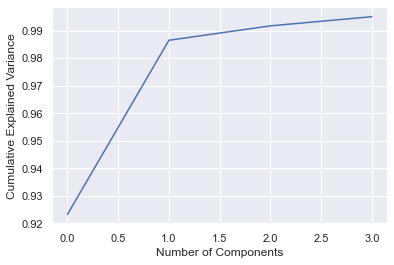

In [11]:
### PCA on numerical variables
pca = PCA(n_components=4)
nums_part = train_df[num_list].reset_index(drop=True)
nums_part = nums_part.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)
pca.fit(nums_part)
# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
nums_part_pca = pca.transform(nums_part)

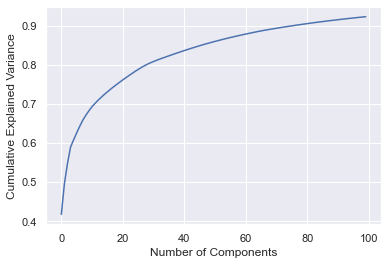

In [12]:
### PCA on categorical variables
pca = PCA(n_components=100)
pca.fit(cates)
# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
cates_pca = pca.transform(cates)

In [13]:
X = pd.concat([pd.DataFrame(nums_part_pca), pd.DataFrame(cates_pca)], axis=1)
X.columns = [x for x in range(len(X.columns.tolist()))]
X['isFraud'] = train_df['isFraud']
X = X.sample(frac=1, replace=False, random_state=42)
X = X.reset_index(drop=True)
y = X['isFraud']
X = X.drop(['isFraud'], axis=1)


### 3. Algorithms Comparison through K-Folds CV

To get a more consistant result, we used K-Fold validations to access our model performance. We first randomly partitioned our data into ten equal parts. One of them is selected to be the test set and the remaining nine parts are used for training. We will train the model on the training set and evaluate its performance on the test set. We will repeat the process ten times and record the average of the accuracy, precision, recall, and f1-score. The purpose of this technique is to provide an estimate of how well the model is likely to perform on unseen data. By testing the model on multiple partitions of the data, the 10-fold cross-validation method provides a more robust estimate of the model's performance than a simple train test split. It can also help to avoid issues such as overfitting to the training data.

In [14]:
def kfold_cv(k, X, y, model):
    kf = KFold(n_splits=k)
    fold = 0
    clf = model
    acc_lst, pre_lst, rec_lst, f1_score_lst= [],[],[],[]
    for train_index, test_index in kf.split(X):
        #Split data        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        score = precision_recall_fscore_support(y_test, y_pred, average='binary')
        acc_lst.append(accuracy)
        pre_lst.append(score[0])
        rec_lst.append(score[1])
        f1_score_lst.append(score[2])
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.show()
        fold+=1
        
    accuracy = np.mean(acc_lst)
    precision = np.mean(pre_lst)
    recall = np.mean(rec_lst)
    f1 = np.mean(f1_score_lst)
    print('Accuracy = ' + str(round(accuracy, 3)))
    print('Precision = ' + str(round(precision, 3)))
    print('Recall = ' + str(round(recall, 3)))
    print('F1 = ' + str(round(f1, 3)))
          
    return accuracy, precision, recall, f1

#### Naive Bayes (Baseline Model)

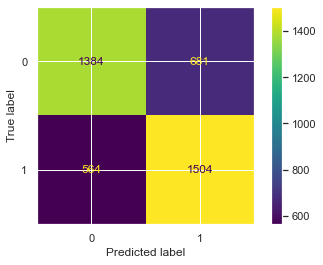

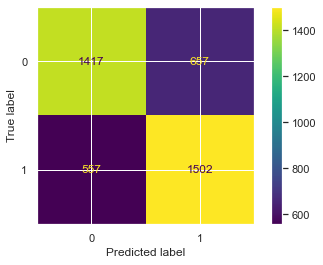

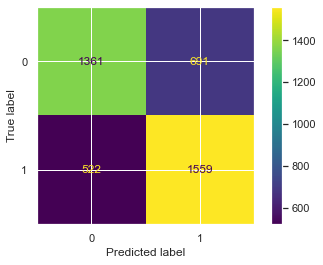

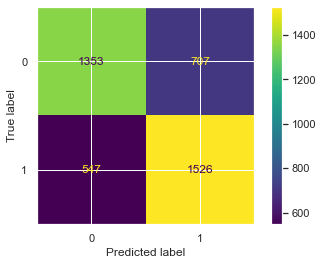

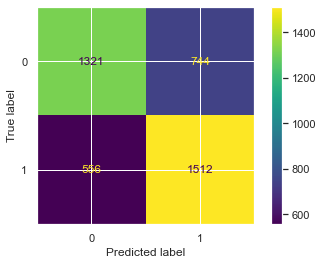

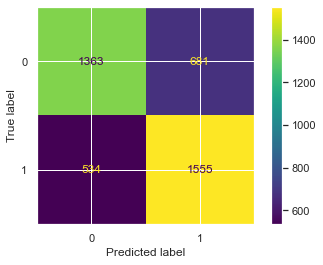

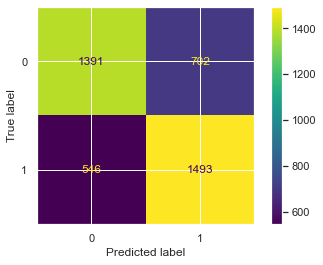

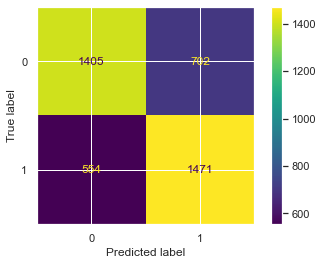

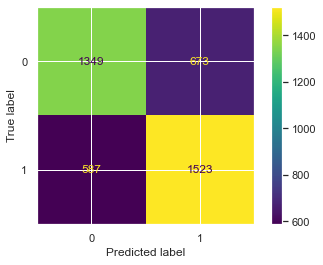

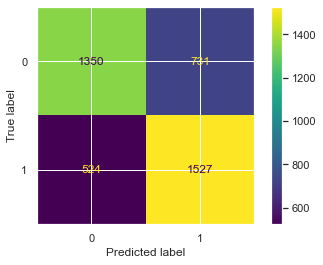

Accuracy = 0.698
Precision = 0.685
Recall = 0.734
F1 = 0.709


In [15]:
nb_model = BernoulliNB()
accuracy, precision, recall, f1 = kfold_cv(10, X, y, nb_model)

#### Random Forest

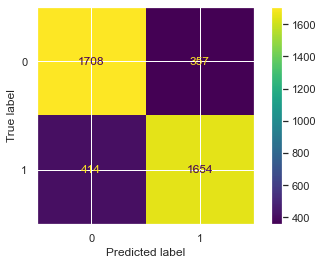

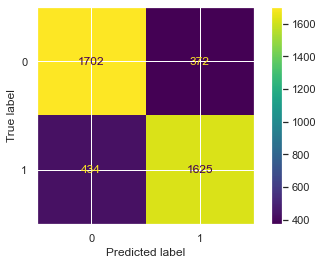

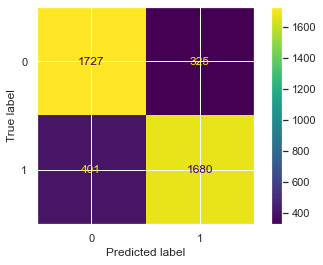

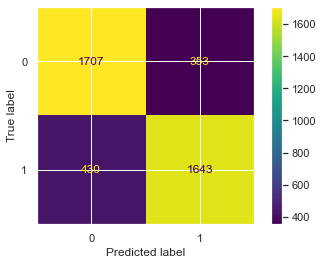

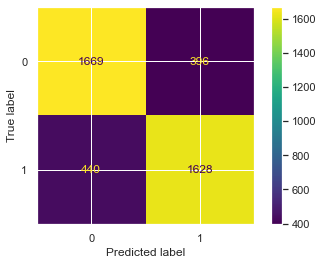

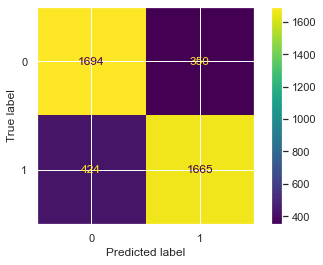

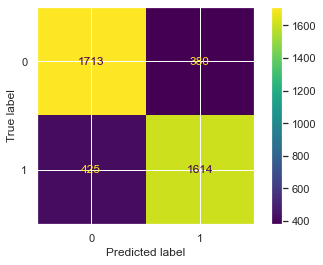

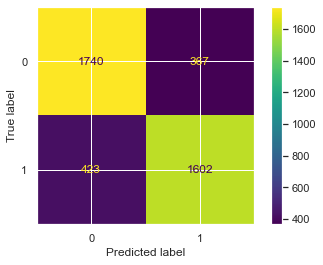

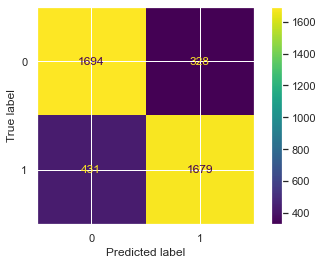

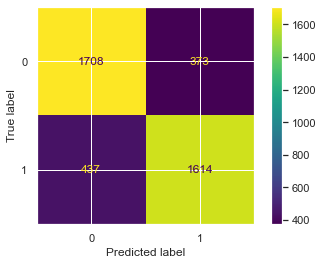

Accuracy = 0.81
Precision = 0.82
Recall = 0.794
F1 = 0.807


In [16]:
rf_model = RandomForestClassifier(random_state=42)
accuracy, precision, recall, f1 = kfold_cv(10, X, y, rf_model)

#### LightGBM

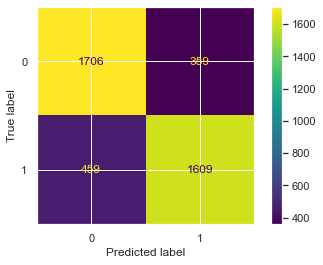

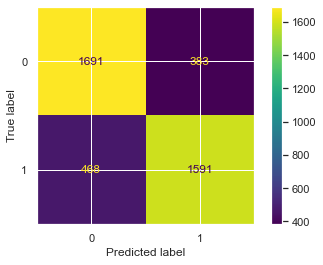

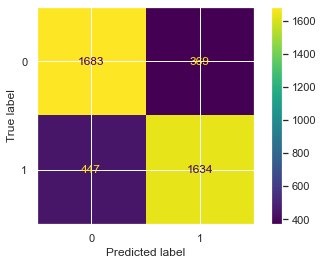

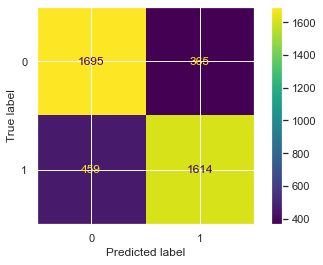

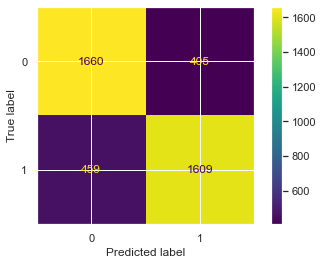

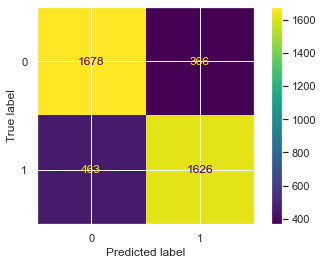

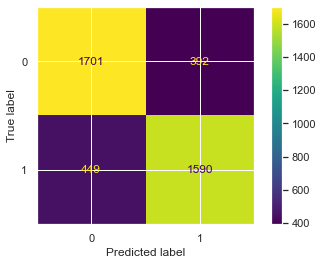

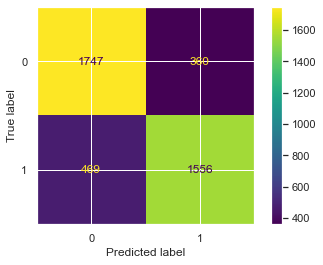

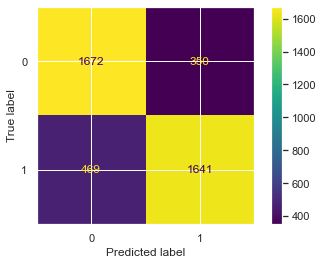

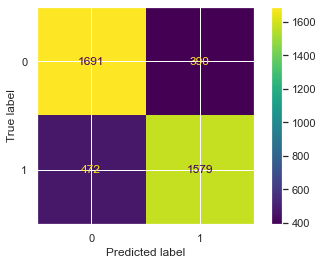

Accuracy = 0.798
Precision = 0.811
Recall = 0.777
F1 = 0.793


In [17]:
lgb_model = lgb.LGBMClassifier(random_state=42)
accuracy, precision, recall, f1 = kfold_cv(10, X, y, lgb_model)

#### XGBoost

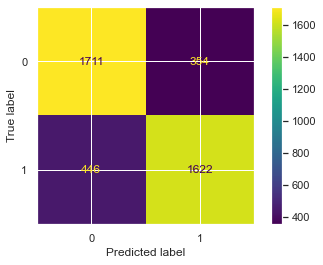

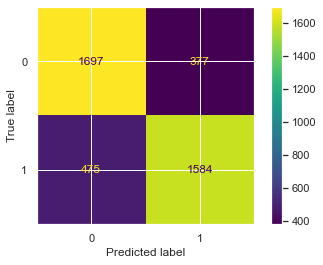

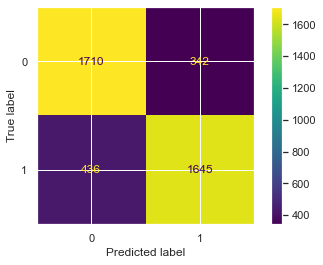

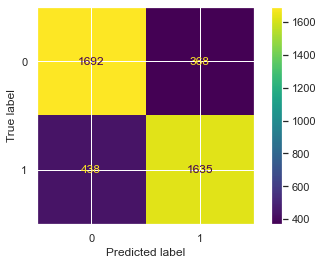

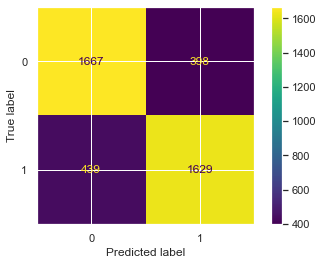

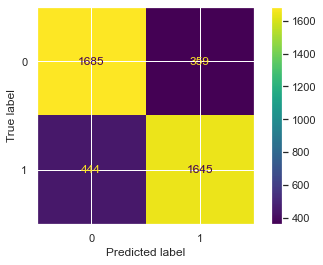

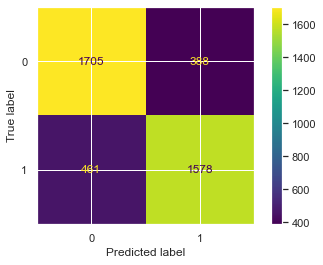

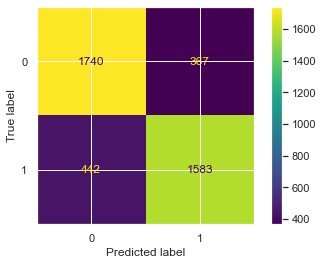

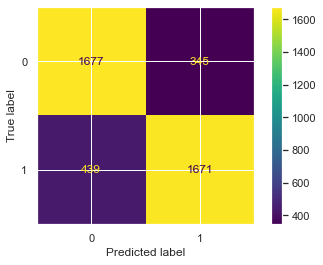

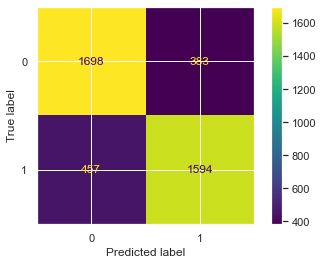

Accuracy = 0.803
Precision = 0.815
Recall = 0.783
F1 = 0.799


In [18]:
xgb_model = xgb.XGBClassifier(random_state=42)
accuracy, precision, recall, f1 = kfold_cv(10, X, y, xgb_model)

According to the accuracy and the recall comparisons from the different algorithms, we decide to choose Random Forest as our most optimal algorithms because it has the highest recall among the four algorithms. In the next step, we will continue the process in searching for the hyperparameters that optimize our model predictions.

### 4. Hyperparameters Tuning through Grid Search - Flame

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.



### 5 Model Evaluation - Yejia

Maybe you do model selection again, but using a different kind of metric than before? ROC curve, confusion matrix


# Discussion

### Interpreting the result - Li ge

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations - Li ge

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

First of all, since this is a public dataset found on Kaggle, it’s likely that it is rather safe regarding ethics and data privacy concerns. Upon examining the dataset, although we have transaction id, there’s no way we could trace it back to find personally identifiable information. Moreover, although we have payment card information, we don’t have card number, but only card type, card category, issue bank, and country, which also isn’t enough to extract personally identifiable information. For the identity part of this dataset, it’s unlikely that there could be ethical or privacy concerns because we don’t actually know what the fields stand for, as they are simply called id2, id3, etc. According to the descriptions, The field names are masked and pairwise dictionaries will not be provided for privacy protection and contract agreement. However, this dataset could be somewhat biased because according to its description, the data is collected by Vesta’s fraud protection system and digital security partners, which is only one or several companies. Thus, this dataset is not guaranteed to be an accurate representation of all transactions that are fraud or not. It is also unlikely that our results could be used unethically because our task tries to identify and prevent frauds, without violating data privacy and without proposing individuals to engage in these illegal activities. 

### Conclusion - Yejia

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="Sasso"></a>1.[^](#Sasso): Sasso, T. (14 Feb 2023) What is Online Transaction Fraud? *Funraise.* https://help.funraise.io/en/articles/3944864-what-is-online-transaction-fraud#:~:text=What%20is%20Transaction%20Fraud%3F%20Transaction%20fraud%20is%20a,a%20transaction%20in%20their%20name%E2%80%94like%20stolen%20credit%20cards. <br> 
<a name="Skiba"></a>2.[^](#Skiba): Skiba, K. (22 Feb 2022) Consumer Fraud Losses Hit Record $5.8 Billion. *AARP.* https://www.aarp.org/money/scams-fraud/info-2022/ftc-fraud-report-new.html <br>
<a name="McKee"></a>3.[^](#McKee): McKee, J. (22 Nov 2022) Unpacking The Overall Impact of Fraud. *Forbes.* https://www.forbes.com/sites/jordanmckee/2020/11/22/unpacking-the-overall-impact-of-fraud/?sh=560a75917891 <br>
<a name="Oakley"></a>4.[^](#Oakley): Oakley, C. (30 March 2022) The role of machine learning in fraud detection. *Featurespace.* https://www.featurespace.com/newsroom/the-role-of-machine-learning-in-fraud-detection/<br> 
<a name="Pykes"></a>5.[^](#Pykes): Pykes, K. (21 Sep 2020) Using Machine Learning To Detect Fraud. *Towards Data Science.* https://towardsdatascience.com/using-machine-learning-to-detect-fraud-f204910389cf <br>
